## Training Binary Classification Model

We have processed our images and augmented our dataset and are ready to train a model. This scripts build on a VGG16 through transfer learning to classify images as Cancer or Normal. 

In [2]:
## install tensorflow to train CNN
!pip install tensorflow

## install opencv to manipulate images
# !pip install opencv-python
# For Sagemeaker:
!pip uninstall opencv-python --yes
!pip install opencv-python-headless


  Using cached tensorflow-2.11.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached libclang-16.0.0-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached protobuf-3.19.6-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached grpcio-1.53.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.0 MB)
  Using cached tensorflow_io_gcs_filesystem-0.32.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached termcolor-2.2.0-py3-none-any.whl (6.6 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.3.3-py2.py3-none-any.whl (26 kB)
  Using cached gast-0.4

In [3]:
## libraries:

import os
import cv2
import numpy as np

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [4]:
## load processed and augmented images
img_extention = (".jpg")
dataset_dir = "../dataset/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/"

neg_prc_imgs_dir = os.path.join(dataset_dir, "processed/no")
pos_prc_imgs_dir = os.path.join(dataset_dir, "processed/yes")

neg_aug_imgs_dir = os.path.join(dataset_dir, "augmented/no")
pos_aug_imgs_dir = os.path.join(dataset_dir, "augmented/yes")

In [5]:
neg_prc_imgs_path = [os.path.join(neg_prc_imgs_dir, file) for file in os.listdir(neg_prc_imgs_dir) if file.lower().endswith(img_extention)]
pos_prc_imgs_path = [os.path.join(pos_prc_imgs_dir, file) for file in os.listdir(pos_prc_imgs_dir) if file.lower().endswith(img_extention)]
neg_aug_imgs_path = [os.path.join(neg_aug_imgs_dir, file) for file in os.listdir(neg_aug_imgs_dir) if file.lower().endswith(img_extention)]
pos_aug_imgs_path = [os.path.join(pos_aug_imgs_dir, file) for file in os.listdir(pos_aug_imgs_dir) if file.lower().endswith(img_extention)]

neg_imgs_path = neg_prc_imgs_path + neg_aug_imgs_path
pos_imgs_path = pos_prc_imgs_path + pos_aug_imgs_path

In [6]:
## load data:

def load_img(img_path):
    img = cv2.imread(img_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255
    return img

## load negative data:
neg_data = []
for img_path in neg_imgs_path:
    img = load_img(img_path)
    neg_data.append(img)

neg_labels = [0] * len(neg_data)


## load positive data:
pos_data = []
for img_path in pos_imgs_path:
    img = load_img(img_path)
    pos_data.append(img)
    
pos_labels = [1] * len(pos_data)

## merge data:

X_data = np.array(neg_data + pos_data)
y_labels = np.array(neg_labels + pos_labels)
#y_labels = to_categorical(y_labels) ## one-hot encoding

In [7]:
## split data as train and test data:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_labels, test_size=0.3, shuffle=True, random_state=1)

## further split the test data into test and validate:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=1)


In [8]:
## check size of each dataset:

print("Training samples: " + str(len(X_train)))
print("Test samples: " + str(len(X_test)))
print("Validation samples: " + str(len(X_val)))

Training samples: 842
Test samples: 253
Validation samples: 109


In [9]:
X_train.shape

(842, 200, 200, 3)

In [10]:
type(X_train)

numpy.ndarray

In [11]:
## load a pre-trained VGG16 model for transfer learning:

from keras.applications.vgg16 import VGG16

img_shape = (200, 200, 3)  ## shape that we saved our images in with the pre-processing script
num_classes = 1            ## binray classification

vgg_model=VGG16(weights="imagenet", input_shape=img_shape, include_top=False)
model= Sequential()
for layer in vgg_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable=False

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

optimizer = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]
             )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 50, 50, 256)       2

In [12]:
%%time

num_epochs = 10
num_batchs = 50

history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = num_batchs, verbose = 1, validation_data = (X_val, y_val))


Epoch 1/10
17/17 [==============================] - 222s 13s/step - loss: 1.6904 - accuracy: 0.5261 - val_loss: 0.6100 - val_accuracy: 0.7156
Epoch 2/10
17/17 [==============================] - 218s 13s/step - loss: 0.4986 - accuracy: 0.7601 - val_loss: 0.5512 - val_accuracy: 0.7706
Epoch 3/10
17/17 [==============================] - 235s 14s/step - loss: 0.4018 - accuracy: 0.8302 - val_loss: 0.4991 - val_accuracy: 0.7982
Epoch 4/10
17/17 [==============================] - 221s 13s/step - loss: 0.3382 - accuracy: 0.8670 - val_loss: 0.4463 - val_accuracy: 0.8257
Epoch 5/10
17/17 [==============================] - 221s 13s/step - loss: 0.2775 - accuracy: 0.9026 - val_loss: 0.3930 - val_accuracy: 0.8716
Epoch 6/10
17/17 [==============================] - 219s 13s/step - loss: 0.2499 - accuracy: 0.9169 - val_loss: 0.3745 - val_accuracy: 0.8807
Epoch 7/10
17/17 [==============================] - 221s 13s/step - loss: 0.1992 - accuracy: 0.9513 - val_loss: 0.3371 - val_accuracy: 0.8991
Epoch 

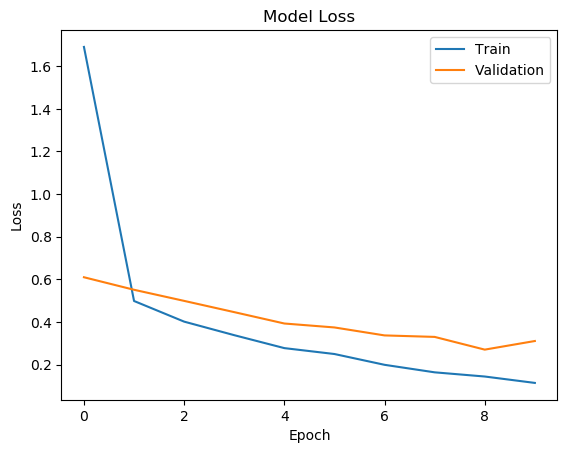

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

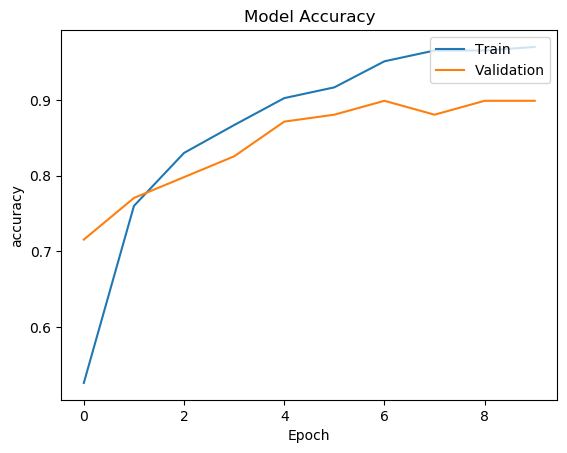

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()



In [15]:
%%time
predictions_prb = model.predict(X_test, verbose=0)
predictions = [1 if num > 0.5 else 0 for num in predictions_prb]

CPU times: user 1min 45s, sys: 7.55 s, total: 1min 52s
Wall time: 1min 22s


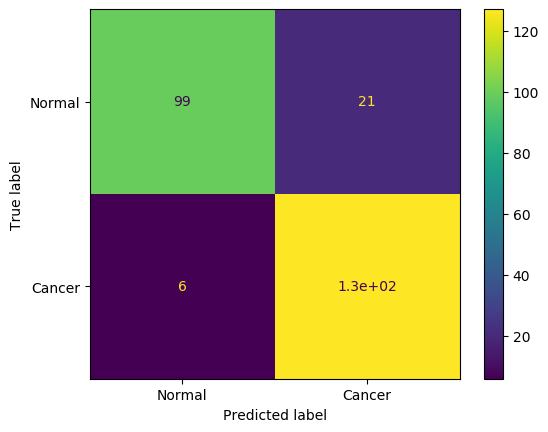

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cfn_mat = confusion_matrix(y_test, predictions)

cfn_plt = ConfusionMatrixDisplay(confusion_matrix=cfn_mat, display_labels=["Normal", "Cancer"])
cfn_plt.plot()
plt.show()

In [17]:
## look at model metrics:
print("Precision = " + str(precision_score(y_test, predictions)))
print("Recall = " + str(recall_score(y_test, predictions)))
print("Accuracy = " + str(accuracy_score(y_test, predictions)))


Precision = 0.8581081081081081
Recall = 0.9548872180451128
Accuracy = 0.8932806324110671


In [18]:
## Save model


import pickle

mdl_output = "detectBC_binaryC_model_v1.pkl"
pickle.dump(model, open(mdl_output, "wb"))

## to load model
# model = pickle.load(open(mdl_output, "rb"))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
............1
......conv2d_7
.........vars
............0
............1
......conv2d_8
.........vars
............0
............1
......conv2d_9
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......max_poolin

In [57]:
# Save data to S3 for persistence

import os
os.makedirs("./data", exist_ok = True)
np.savez('./data/training', image = X_train, label = y_train)
np.savez('./data/validation', image = X_val, label = y_val)
np.savez('./data/test', image = X_test, label = y_test)

In [58]:
# Upload the training and validation data to S3 bucket

import sagemaker

# Sagemaker session
sagemaker_session = sagemaker.Session()

# Data location S3 bucket and prefix
prefix = 'cnn-training-data'

# Execution role:
role = sagemaker.get_execution_role()


training_dir   = sagemaker_session.upload_data('data/training.npz', key_prefix = prefix + '/training')
validation_dir = sagemaker_session.upload_data('data/validation.npz', key_prefix = prefix + '/validation')
test_dir = sagemaker_session.upload_data('data/test.npz', key_prefix = prefix + '/test')

print(training_dir)
print(validation_dir)
print(test_dir)

s3://sagemaker-us-east-1-969844977961/cnn-training-data/training/training.npz
s3://sagemaker-us-east-1-969844977961/cnn-training-data/validation/validation.npz
s3://sagemaker-us-east-1-969844977961/cnn-training-data/test/test.npz


## Train through SageMaker

In [20]:
import sagemaker
import boto3

# Sagemaker session
sm_sess = sagemaker.Session()

# Data location S3 bucket and prefix
bucket = 'brain-cancer-dataset'
prefix = 'raw'

# Execution role:
role = sagemaker.get_execution_role()

In [21]:
# Reference: https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#deploy-tensorflow-serving-models

from sagemaker.tensorflow import TensorFlow



tf_estimator = TensorFlow(entry_point='train_cnn.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m5.large',
                          framework_version='2.11', 
                          py_version='py39',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 20 ,
                              'batch-size': 50,
                              'learning-rate': 0.001,
                              'image-shape': '200x200x3'}
                         )



In [22]:
training_dir = 's3://sagemaker-us-east-1-969844977961/cnn-training-data/training/training.npz'
validation_dir = 's3://sagemaker-us-east-1-969844977961/cnn-training-data/validation/validation.npz'
test_dir = 's3://sagemaker-us-east-1-969844977961/cnn-training-data/test/test.npz'

In [23]:
tf_estimator.fit({'training': training_dir,
                  'validation': validation_dir,
                  'test': test_dir})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-03-29-19-05-10-648


2023-03-29 19:05:14 Starting - Starting the training job...
2023-03-29 19:05:30 Starting - Preparing the instances for training...
2023-03-29 19:06:17 Downloading - Downloading input data.........
2023-03-29 19:07:23 Training - Downloading the training image...
2023-03-29 19:08:18 Training - Training image download completed. Training in progress..2023-03-29 19:08:20.385444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 19:08:20.495728: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-03-29 19:08:20.496283: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, futur

UnexpectedStatusException: Error for Training job tensorflow-training-2023-03-29-19-05-10-648: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
ExitCode 1
ErrorMessage "NotImplementedError: in user code
 
 File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
 return step_function(self, iterator)
 File "/usr/local/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 169, in wrapper  *
 return func(*args, **kwargs)
 File "/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 221, in accuracy_score  *
 y_type, y_true, y_pred = _check_targets(y_true, y_pred)
 File "/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 86, in _check_targets  *
 check_consistent_length(y_true, y_pred)
 File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 395, in check_consistent_length  *
 uniques = np.unique(lengths)
 File "<__array_function__ internals>", line 180, in unique  **
 File "/usr/local/lib/python3.9/site-packages/numpy/lib/arraysetops.py", line 272, in unique
 ar = np.asanya

In [30]:
tf_predictor = tf_estimator.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

ValueError: Estimator is not associated with a training job

In [ ]:
## model evaluation:

predictions_prb = tf_predictor.predict(X_test, verbose=0)
predictions = [1 if num > 0.5 else 0 for num in predictions_prb]

print("Precision = " + str(precision_score(y_test, predictions)))
print("Recall = " + str(recall_score(y_test, predictions)))
print("Accuracy = " + str(accuracy_score(y_test, predictions)))

cfn_mat = confusion_matrix(y_test, predictions)
cfn_plt = ConfusionMatrixDisplay(confusion_matrix=cfn_mat, display_labels=["Normal", "Cancer"])
cfn_plt.plot()
plt.show()

In [ ]:
# Deleting the end-point
# tf_predictor.delete_endpoint()

# Training via a sagemaker estimator and a custom docker image